# 使用FFMPEG来处理视频

In [3]:
from ipywidgets import interact
from matplotlib import pyplot as plt
import ffmpeg
import ipywidgets as widgets
import numpy as np

In [5]:
probe = ffmpeg.probe('MakeUp.mp4')
video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
width = int(video_info['width'])
height = int(video_info['height'])
num_frames = int(video_info['nb_frames'])

In [7]:
out, err = (
    ffmpeg
    .input('MakeUp.mp4')
    .output('pipe:', format='rawvideo', pix_fmt='rgb24')
    .run(capture_stdout=True)
)
video = (
    np
    .frombuffer(out, np.uint8)
    .reshape([-1, height, width, 3])
)

@interact(frame=(0, num_frames))
def show_frame(frame=0):
    plt.imshow(video[frame,:,:,:])

interactive(children=(IntSlider(value=0, description='frame', max=1092), Output()), _dom_classes=('widget-inte…

interactive(children=(Checkbox(value=True, description='enable_overlay'), Checkbox(value=True, description='en…

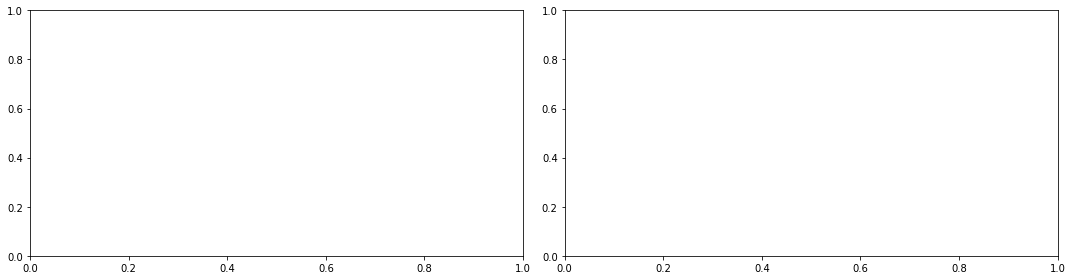

In [8]:
from io import BytesIO
from PIL import Image
    
def extract_frame(stream, frame_num):
    while isinstance(stream, ffmpeg.nodes.OutputStream):
        stream = stream.node.incoming_edges[0].upstream_node.stream()
    out, _ = (
        stream
        .filter_('select', 'gte(n,{})'.format(frame_num))
        .output('pipe:', format='rawvideo', pix_fmt='rgb24', vframes=1)
        .run(capture_stdout=True, capture_stderr=True)
    )
    return np.frombuffer(out, np.uint8).reshape([height, width, 3])


def png_to_np(png_bytes):
    buffer = BytesIO(png_bytes)
    pil_image = Image.open(buffer)
    return np.array(pil_image)
    

def build_graph(
        enable_overlay, flip_overlay, enable_box, box_x, box_y,
        thickness, color):

    stream = ffmpeg.input('MakeUp.mp4')

    if enable_overlay:
        overlay = ffmpeg.input('overlay.png')
        if flip_overlay:
            overlay = overlay.hflip()
        stream = stream.overlay(overlay)

    if enable_box:
        stream = stream.drawbox(
            box_x, box_y, 120, 120, color=color, t=thickness)

    return stream.output('out.mp4')


def show_image(ax, stream, frame_num):
    try:
        image = extract_frame(stream, frame_num)
        ax.imshow(image)
        ax.axis('off')
    except ffmpeg.Error as e:
        print(e.stderr.decode())


def show_graph(ax, stream, detail):
    data = ffmpeg.view(stream, detail=detail, pipe=True)
    image = png_to_np(data)
    ax.imshow(image, aspect='equal', interpolation='hanning')
    ax.set_xlim(0, 1100)
    ax.axis('off')


@interact(
    frame_num=(0, num_frames),
    box_x=(0, 200),
    box_y=(0, 200),
    thickness=(1, 40),
    color=['red', 'green', 'magenta', 'blue'],
)
def f(
        enable_overlay=True,
        enable_box=True,
        flip_overlay=True,
        graph_detail=False,
        frame_num=0,
        box_x=50,
        box_y=50,
        thickness=5,
        color='red'):

    stream = build_graph(
        enable_overlay,
        flip_overlay,
        enable_box,
        box_x,
        box_y,
        thickness,
        color
    )

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,4))
    plt.tight_layout()
    show_image(ax0, stream, frame_num)
    show_graph(ax1, stream, graph_detail)